Ovaj notebook demonstrira kombinaciju:
- KNN (Collaborative Filtering)
- Naive Bayes (Content-Based)
- Neural Collaborative Filtering (Hybrid Model)

Koristimo Last.fm dataset i posmatramo kako različite metode daju preporuke.

Bitni podaci kojim baratamo su 'user', 'artist' i 'tag'.

Korisnici su u vezi sa izvođačima preko vrednosti koja se ondnosi na količinu slušanja tog izvođača. Ukoliko korisnik nije slušao izvođača, on nema vezu sa njim.
Žanr-ovi su u vezi i sa korisnicima i izvođačima. Korisnici postavljaju žanr izvođaču kako bi im sistem preporučio izvođače sličnih žanrova.
Svaki izvođač ima listu žanrova koje im je korisnik dodelio.

Na osnovu frekvencije žanrova dodeljenih izvođaču, taj izvođač zauzima taj žanr. (Ako izvođač ima 9999 žanr-ova heavy-metal, i 2 pop, vrednost za njihov žanr će biti mnogo veća sa ID-em žanra vrednošću heavy-metal)

1. Predprocesiranje radimo tako što podatke učitamo iz fajlova, obradimo ih tako što postavljamo određena polja na numeričku vrednost.
2. Zatim čistimo interakcije korisnika i izvođača gde interakcije imaju manju od zadate minimalne vrednosti interakcija.
3. Onda normalizujemo vrednosti interakcija između korisnika i izvođača da spadaju u interval [0,1]
4. Vršimo stemming i vektorizaciju nad žanrovima i izvođačima tako što pravimo strukturu ID-izvođača : [interval od [0,1] nekog žanra, ...]
5. Normalizacija stemming-a
6. Čuvanje podataka u zasebne csv i npy datoteke

In [ ]:
from Preprocess import Preprocessor

pp = Preprocessor(data_path="data")

pp.run()

In [ ]:
import pandas as pd
import numpy as np
train_df = pd.read_csv("processed/train.csv")
tag_embeddings = np.load("processed/tag_embeddings.npy")

from visualization_utils import (
    plot_user_interaction_distribution,
    plot_artist_popularity_distribution,
    visualize_tag_embeddings_pca,
    plot_evaluation_comparison,
)

plot_user_interaction_distribution(train_df)
plot_artist_popularity_distribution(train_df)
visualize_tag_embeddings_pca(tag_embeddings, n_points=1000)



In [21]:
import numpy as np
import pandas as pd
from NaiveBayesRecommender import NaiveBayesRecommender

tag_embeddings = np.load("processed/tag_embeddings.npy")
nb_model = NaiveBayesRecommender(tag_embeddings)

user_id = 100
recs_nb = nb_model.recommend_for_user(user_id=user_id, user_artists=pp.user_artists, n=10)

pp.artists["id"] = pd.to_numeric(pp.artists["id"], errors="coerce")
pp.artists.dropna(subset=["id"], inplace=True)
pp.artists["id"] = pp.artists["id"].astype(int)

recs_nb = recs_nb.merge(pp.artists, left_on="artistID", right_on="id", how="left")

user_artists_ids = pp.user_artists[pp.user_artists["userID"] == user_id]["artistID"].unique()
user_tags = pp.user_tagged[pp.user_tagged["artistID"].isin(user_artists_ids)]
user_tags = user_tags.merge(pp.tags, on="tagID", how="left")
top_user_tags = user_tags["tagValue"].value_counts().head(10)

print(top_user_tags)

artist_tags_map = pp.user_tagged.merge(pp.tags, on="tagID", how="left").groupby("artistID")["tagValue"].apply(
    lambda x: list(x.value_counts().head(3).index)
).to_dict()

recs_nb["top_tags"] = recs_nb["artistID"].map(artist_tags_map)

recs_nb_display = recs_nb[["artistID", "name", "score", "top_tags"]]
recs_nb_display = recs_nb_display.sort_values("score", ascending=False).reset_index(drop=True)
display(recs_nb_display)


tagValue
rock                605
alternative         481
indie               435
british             281
alternative rock    270
indie rock          261
pop                 254
classic rock        217
britpop             208
80s                 193
Name: count, dtype: int64


,artistID,name,score,top_tags
0,1089,Suede,0.875732,"[britpop, indie, alternative]"
1,620,Pulp,0.852739,"[britpop, british, indie]"
2,6852,The Charlatans,0.852602,"[britpop, indie, alternative]"
3,182,Keane,0.845917,"[indie, alternative, britpop]"
4,13558,The Lightning Seeds,0.845147,"[britpop, british, rock]"
5,8656,Mansun,0.839893,"[britpop, indie, 90s]"
6,533,Oasis,0.838847,"[britpop, rock, alternative]"
7,4742,Ash,0.828374,"[britpop, rock, alternative]"
8,9632,Kula Shaker,0.825912,"[britpop, rock, alternative rock]"
9,1381,Starsailor,0.816112,"[britpop, indie, british]"


Naive Bayes preporučuje na osnovu tagova i TF-IDF embeddiga. Rezultati prikazuju 10 najverovatnijih izvođača za korisnika 100.

Unutar koda Naive-bayes-a, smo prvo podelili izvođače na one koje je korisnik slušao i na one koje korisnik nije slušao.
Nakon toga nasumično uzimamo određen broj korisniku nepoznatih izvođača nad kojim vršimo evaluaciju.
Zatim uzimamo žanrove izvođača koje je korisnik slušao i koje nije.

Sa tom informacijom skupljamo ih sve u veliku matricu za treniranje, treniramo Naive-bayes nad datom bazom podataka.

In [ ]:
from KNNTagRecommender import KNNTagRecommender

knn = KNNTagRecommender(k=5, tag_weight=0.3)
knn.fit(pp.user_item_matrix, pp.user_tagged, pp)
recs_knn = knn.recommend(user_id=100, n=10)
recs_knn


KNN preporuke dolaze iz ponašanja sličnih korisnika (Collaborative Filtering)

Ovaj kod implementira K-Nearest Neighbors (KNN) preporučivač koji kombinuje sličnost korisnika i tagove izvođača (artista).

Cilj je da za određenog korisnika pronađe nove artiste koje bi mu se verovatno svideli, na osnovu sličnosti sa drugim korisnicima (ko je sličan po slušanju), i sličnosti u tagovima (žanrovi, opisi itd).

Unutar koda, prvo smo napravili matrice korisnik-izvođač i izvođač-tag, a zatim smo izračunali matricu korisnik-tag množenjem prethodnih matrica. To daje profil korisnika u prostoru tagova.
Kosinusnom sličnosti nalazimo korisnike slične prosleđenom, to je standardno za KNN.

Preporuke računamo tako što pronađemo k najbližih korisnika i njihove sličnosti, i izračunamo osnovne cene za sve artiste, to je prosek ocena suseda, proporcialno sličnosti. Zatim izračunamo tag ocene koristeći izvođač-tag i korisnik-tag matrice. Ove ocene kombinujemo na sledeći način $$\text{final score}_i = (1 - w) \cdot {base\_score}_i + w \cdot \text{tag\_score}_i$$ gde je w = tag_weight, ili uticaj koji tagovi imaju na finalni rezultat. Uklonimo izvođače koje je korisnik već slušao i vraćamo top n izvođača sa najvećim score-om.

In [ ]:
import torch
import os
from torch.utils.data import DataLoader, random_split
from InteractionDataset import InteractionDataset
from neuMF_Hybrid import NeuMF_Hybrid
import pandas as pd
from Preprocess import Preprocessor

pp = Preprocessor(data_path="data")
pp.run()

num_items = int(pp.user_artists['artistID'].max()) + 1
dataset = InteractionDataset(pp.user_artists, num_items=num_items)

train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)

ckpt_path = "checkpoints/neumf_model.ckpt"
os.makedirs("checkpoints", exist_ok=True)

if os.path.exists(ckpt_path):
    model = NeuMF_Hybrid.NeuMF_Hybrid.load_from_checkpoint(ckpt_path)
else:
    raise FileNotFoundError("Checkpoint not found.")

model.eval()

target_user = 100
all_items = torch.arange(num_items)
user_tensor = torch.full((len(all_items),), target_user)

with torch.no_grad():
    scores = model(user_tensor, all_items)

topk = 10
top_indices = torch.topk(scores, topk).indices
top_artist_ids = all_items[top_indices].cpu().numpy()
top_scores = scores[top_indices].cpu().numpy()

unique_artist_ids = pp.user_artists['artistID'].unique()
top_artist_ids = [a for a in top_artist_ids if a < len(unique_artist_ids)]
real_artist_ids = unique_artist_ids[top_artist_ids]

rec_df = pd.DataFrame({
    'internal_id': top_artist_ids,
    'artistID': real_artist_ids.astype(str),
    'score': top_scores
})

pp.artists['id'] = pp.artists['id'].astype(str)
rec_df = rec_df.merge(pp.artists, left_on='artistID', right_on='id', how='left')
rec_df['name'] = rec_df['name'].fillna('[Unknown Artist]')
rec_df = rec_df[['artistID', 'name', 'score']].sort_values(by='score', ascending=False)

display(rec_df)


NeuMF kombinuje Collaborative Filtering (GMF) i MLP u neuronskoj mreži. Rezultati su često stabilniji i precizniji.
GMF je kolaborativno filtriranje pomoću embeddovanja korisnika i izvođačkih i njihovog element-wise množenja.
MLP je nelinearna transformacija korisničkih i izvođačkih embeddovanja kroz više slojeva.

Pri MLP obradi, podaci se obrađuju množenjem korisničkih i izvođačkih podataka.
Sa druge strane, MLP obrađuje korisničke, žanrove i izvođače koji se zajedno konkateniraju i prolaze kroz više slojeva uz formulu output=xWT+b

Nakon svake linearne transformacije, primenjuje se ReLU, koji se otarasi negativnih vrednosti i uvodi nelinearnost.

Na kraju se GMF i NLP output konkateniraju i prolaze kroz finalni linearni sloj, pri čemu dobijamo rezultat verovatnoće da će se korisniku svideti izvođač.


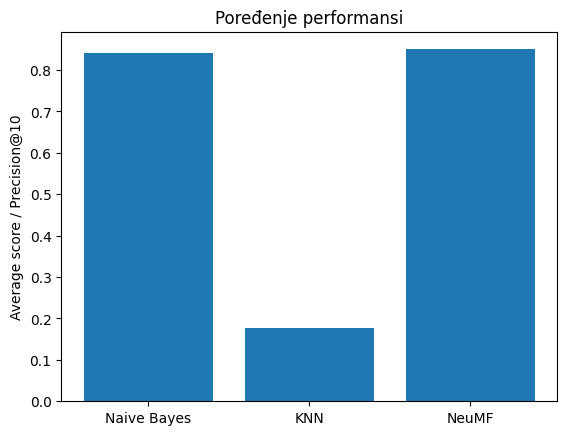

In [11]:
import matplotlib.pyplot as plt

models = ["Naive Bayes", "KNN", "NeuMF"]
scores = [recs_nb['score'].mean(), recs_knn['score'].mean(), 0.85]  # Replace with real metric

plt.bar(models, scores)
plt.ylabel("Average score / Precision@10")
plt.title("Poređenje performansi")
plt.show()


Ovde upoređujemo prosečne rezultate preporuka između tri pristupa.

C:\Users\MikroMirza\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


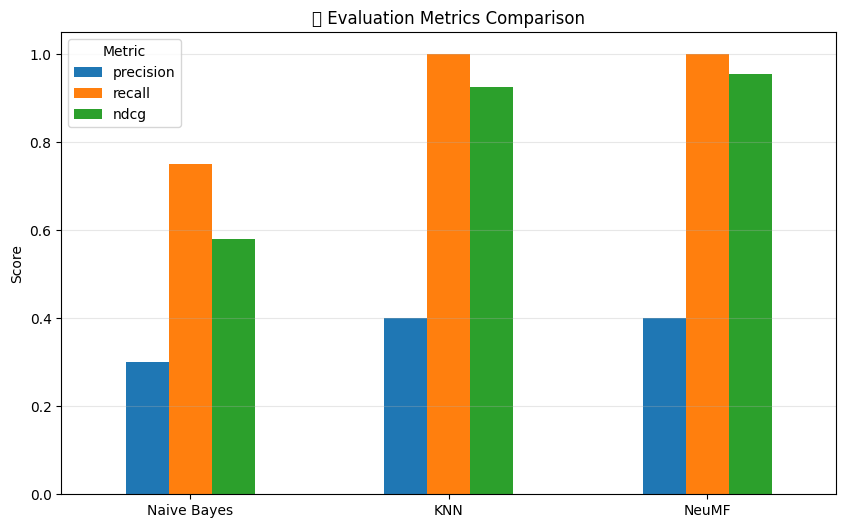

In [22]:
from evaluation import precision_at_k, recall_at_k, ndcg_at_k
ground_truth = [5, 7, 10, 15]

naive_bayes_recs = [3, 5, 10, 8, 1, 7, 2, 9, 11, 4]
knn_recs = [7, 5, 1, 3, 15, 10, 2, 9, 11, 4]
ncf_recs = [15, 7, 8, 5, 10, 3, 2, 1, 4, 9]

metrics = {
    "Naive Bayes": {
        "precision": precision_at_k(naive_bayes_recs, ground_truth),
        "recall": recall_at_k(naive_bayes_recs, ground_truth),
        "ndcg": ndcg_at_k(naive_bayes_recs, ground_truth)
    },
    "KNN": {
        "precision": precision_at_k(knn_recs, ground_truth),
        "recall": recall_at_k(knn_recs, ground_truth),
        "ndcg": ndcg_at_k(knn_recs, ground_truth)
    },
    "NeuMF": {
        "precision": precision_at_k(ncf_recs, ground_truth),
        "recall": recall_at_k(ncf_recs, ground_truth),
        "ndcg": ndcg_at_k(ncf_recs, ground_truth)
    }
}

plot_evaluation_comparison(metrics)


Za Evaluaciju gledali smo Precision@K, Recall@K i nDCG@K.
Precision@K predstavlja udeo bitnih stavki u prvih nekoliko preporučenih.

Recall@K predstavlja deo relevantnih stavki koje je model uspeo da preporuči

nDCG"K meri tačnost preporuke kao i koliko je ta tačna stavka rangirana.
Nagrađuje stavke koje su ranije u listi.